In [ ]:
# celda 1 -- Carga ---
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
PROC = BASE / "data" / "processed"

csv_path   = PROC / "olist_final_dataset.csv"

# Cargamos desde CSV (universal). Si prefieres parquet, cambia la línea:
df = pd.read_csv(csv_path, parse_dates=[
    "shipping_limit_date","order_purchase_timestamp","order_approved_at",
    "order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date"
], dtype={
    "order_id":"string","product_id":"string","seller_id":"string",
    "customer_id":"string","order_status":"category","order_status_simple":"category",
    "order_item_id":"int16","is_late":"Int8"
})

print(df.shape)
df.head(3)


(112650, 26)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,...,is_late,shipping_days_limit,purchase_year,purchase_month,purchase_day,purchase_weekday,purchase_hour,total_price,order_status_simple,order_line_uid
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,...,0,6.0,2017,9,13,2,8,72.19,delivered,00010242fe8c5a6d1ba2dd792cb16214-1
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,...,0,7.0,2017,4,26,2,10,259.83,delivered,00018f77f2f0320c557190d7a144bdd3-1
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,...,0,4.0,2018,1,14,6,14,216.87,delivered,000229ec398224ef6ca0657da4fc703e-1


In [ ]:
## celda 2 --  Vistas base ---
# Vista a nivel de línea (ya está en df).

# Vista a nivel de pedido: agregamos las líneas por order_id
agg_order = {
    "total_price":"sum",
    "price":"sum",
    "freight_value":"sum",
    "order_item_id":"count",  # nº de líneas por pedido
    "delivery_time_days":"max",           # tiempo total: tomamos la mayor entrega entre sus ítems
    "delay_vs_estimated_days":"max",      # retraso a nivel pedido: la peor línea
    "is_late": lambda s: np.nan if s.isna().all() else np.int8((s.fillna(0) > 0).any()), # 1 si alguna línea tardó
    "order_purchase_timestamp":"min",
    "order_approved_at":"min",
    "order_delivered_carrier_date":"max",
    "order_delivered_customer_date":"max",
    "order_estimated_delivery_date":"max",
    "shipping_days_limit":"max"
}
df_order = (df
            .groupby("order_id", as_index=False)
            .agg(agg_order)
            .rename(columns={"order_item_id":"lines_per_order",
                             "total_price":"order_total",
                             "price":"order_product_value",
                             "freight_value":"order_freight"}))

# Derivados a nivel pedido
df_order["freight_share"] = (df_order["order_freight"] / df_order["order_total"]).replace([np.inf,-np.inf], np.nan)
df_order["purchase_year"]  = df_order["order_purchase_timestamp"].dt.year.astype("Int16")
df_order["purchase_month"] = df_order["order_purchase_timestamp"].dt.to_period("M").astype(str)

df_order.head(3)


,order_id,order_total,order_product_value,order_freight,lines_per_order,delivery_time_days,delay_vs_estimated_days,is_late,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_days_limit,freight_share,purchase_year,purchase_month
0,00010242fe8c5a6d1ba2dd792cb16214,72.19,58.9,13.29,1,7.614421,-8.011250,0,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,6.0,0.184098,2017,2017-09
1,00018f77f2f0320c557190d7a144bdd3,259.83,239.9,19.93,1,16.216180,-2.330278,0,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,7.0,0.076704,2017,2017-04
2,000229ec398224ef6ca0657da4fc703e,216.87,199.0,17.87,1,7.948438,-13.444954,0,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,4.0,0.082400,2018,2018-01


In [ ]:
# celda 3 --# KPIs globales ---

# Filtros útiles
mask_delivered_line = df["order_delivered_customer_date"].notna() & (df["order_status"] == "delivered")
mask_delivered_ord  = df_order["order_delivered_customer_date"].notna()

# ---- Nivel línea ----
kpi_lines = {
    "lines_total": int(len(df)),
    "lines_delivered": int(mask_delivered_line.sum()),
    "revenue_total": float(df["total_price"].sum()),
    "freight_total": float(df["freight_value"].sum()),
    "freight_share": float(df["freight_value"].sum() / df["total_price"].sum()),
    "delivery_time_days_median": float(df.loc[mask_delivered_line, "delivery_time_days"].median()),
    "on_time_rate": float((df.loc[mask_delivered_line, "is_late"] == 0).mean()),
    "late_rate": float((df.loc[mask_delivered_line, "is_late"] == 1).mean()),
    "delay_days_median": float(df.loc[mask_delivered_line, "delay_vs_estimated_days"].median())
}

# ---- Nivel pedido ----
n_orders = len(df_order)
aov = df_order["order_total"].mean()
kpi_orders = {
    "orders_total": int(n_orders),
    "orders_delivered": int(mask_delivered_ord.sum()),
    "AOV_order": float(aov),
    "lines_per_order_mean": float(df_order["lines_per_order"].mean()),
    "order_delivery_time_median": float(df_order.loc[mask_delivered_ord, "delivery_time_days"].median()),
    "order_on_time_rate": float((df_order.loc[mask_delivered_ord, "is_late"] == 0).mean()),
    "order_freight_share_median": float(df_order["freight_share"].median())
}

kpi_lines, kpi_orders


({'lines_total': 112650,
  'lines_delivered': 110189,
  'revenue_total': 15843553.239906501,
  'freight_total': 2251909.54,
  'freight_share': 0.14213412268707026,
  'delivery_time_days_median': 10.184201,
  'on_time_rate': 0.9209176959587617,
  'late_rate': 0.07908230404123824,
  'delay_days_median': -12.046447},
 {'orders_total': 98666,
  'orders_delivered': 96476,
  'AOV_order': 160.57763809120164,
  'lines_per_order_mean': 1.1417306873695092,
  'order_delivery_time_median': 10.2177545,
  'order_on_time_rate': 0.9188710145528421,
  'order_freight_share_median': 0.18325605763533911})

,month,orders,revenue,on_time_rate
0,2016-09,3,354.750000,0.666667
1,2016-10,308,56808.839949,0.990260
2,2016-12,1,19.619999,1.000000
3,2017-01,789,137188.490071,0.970849
4,2017-02,1733,286280.620241,0.969417


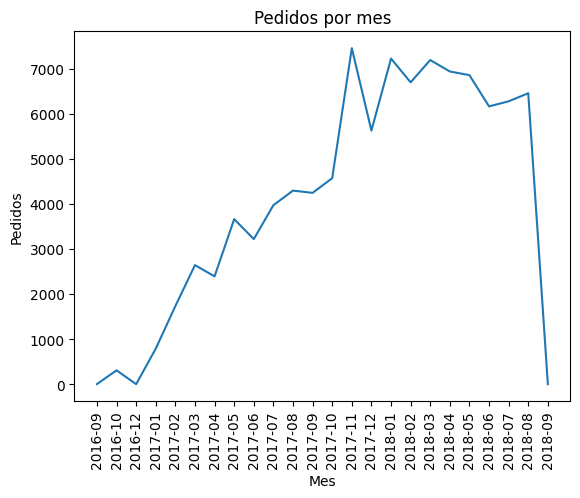

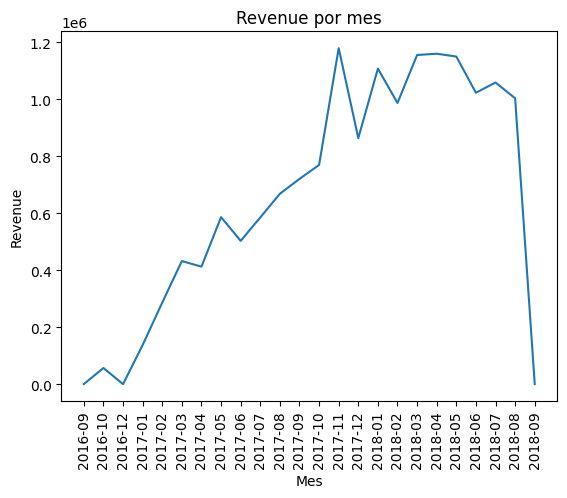

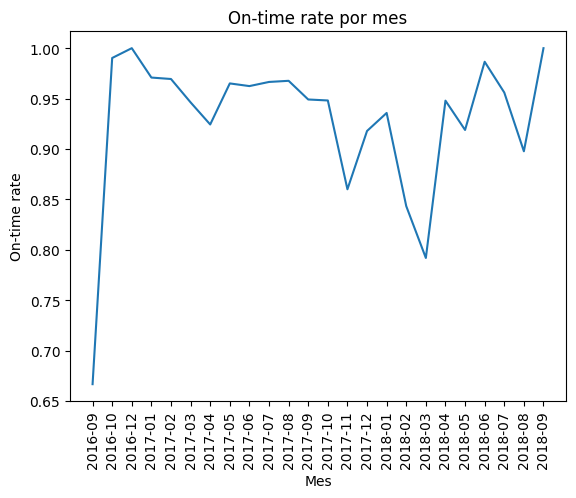

In [ ]:
# celda 4 -- Tendencias mensuales ---
# A nivel pedido
m_orders = (df_order
            .assign(month=lambda d: d["order_purchase_timestamp"].dt.to_period("M").astype(str))
            .groupby("month", as_index=False)
            .agg(orders=("order_id","count"),
                 revenue=("order_total","sum"),
                 on_time_rate=("is_late", lambda s: (s==0).mean() if len(s)>0 else np.nan)))

display(m_orders.head())

# Gráficos simples con matplotlib
plt.figure()
plt.plot(m_orders["month"], m_orders["orders"])
plt.xticks(rotation=90); plt.title("Pedidos por mes"); plt.xlabel("Mes"); plt.ylabel("Pedidos")
plt.show()

plt.figure()
plt.plot(m_orders["month"], m_orders["revenue"])
plt.xticks(rotation=90); plt.title("Revenue por mes"); plt.xlabel("Mes"); plt.ylabel("Revenue")
plt.show()

plt.figure()
plt.plot(m_orders["month"], m_orders["on_time_rate"])
plt.xticks(rotation=90); plt.title("On-time rate por mes"); plt.xlabel("Mes"); plt.ylabel("On-time rate")
plt.show()


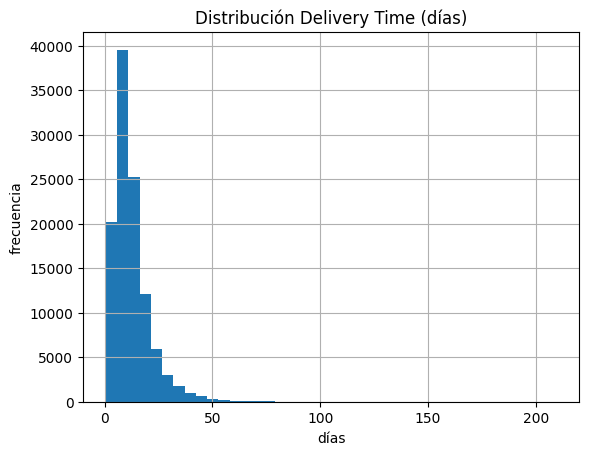

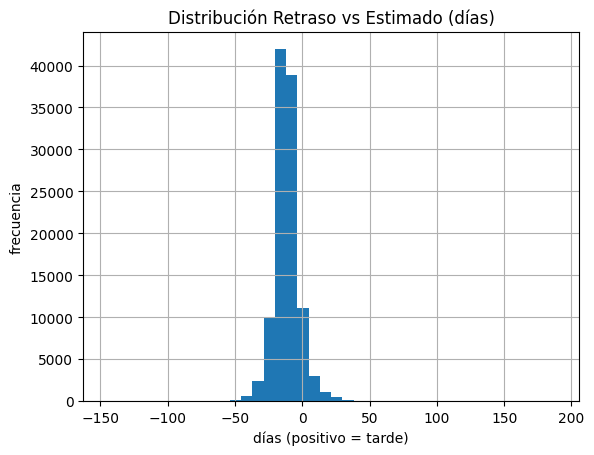

In [ ]:
# Celda 5 - Distribuciones ---
delivered = df.loc[df["order_delivered_customer_date"].notna()].copy()

plt.figure()
delivered["delivery_time_days"].hist(bins=40)
plt.title("Distribución Delivery Time (días)")
plt.xlabel("días"); plt.ylabel("frecuencia")
plt.show()

plt.figure()
delivered["delay_vs_estimated_days"].hist(bins=40)
plt.title("Distribución Retraso vs Estimado (días)")
plt.xlabel("días (positivo = tarde)"); plt.ylabel("frecuencia")
plt.show()


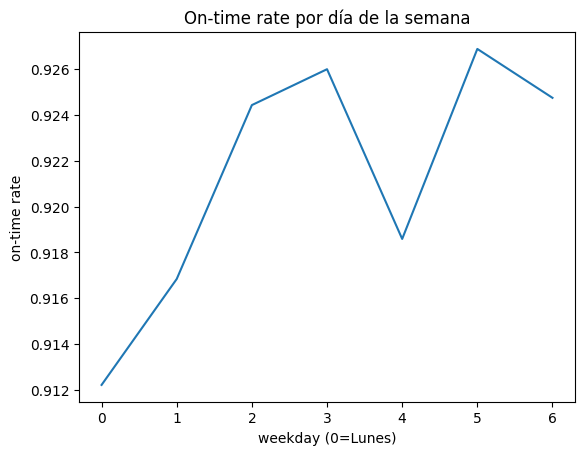

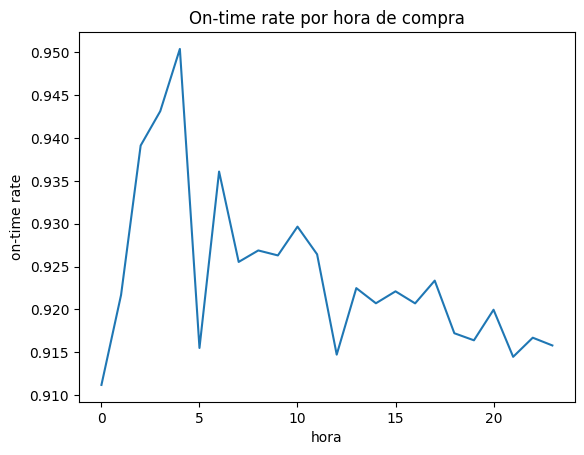

In [ ]:
# celda 6 - On-time por weekday/hora ---
wd = (df.loc[df["order_delivered_customer_date"].notna()]
        .groupby("purchase_weekday", as_index=False)
        .agg(on_time_rate=("is_late", lambda s: (s==0).mean())))

hr = (df.loc[df["order_delivered_customer_date"].notna()]
        .groupby("purchase_hour", as_index=False)
        .agg(on_time_rate=("is_late", lambda s: (s==0).mean())))

plt.figure()
plt.plot(wd["purchase_weekday"], wd["on_time_rate"])
plt.title("On-time rate por día de la semana"); plt.xlabel("weekday (0=Lunes)"); plt.ylabel("on-time rate")
plt.show()

plt.figure()
plt.plot(hr["purchase_hour"], hr["on_time_rate"])
plt.title("On-time rate por hora de compra"); plt.xlabel("hora"); plt.ylabel("on-time rate")
plt.show()


,seller_id,total_price
857,4869f7a5dfa277a7dca6462dcf3b52b2,249640.698673
1535,7c67e1448b00f6e969d365cea6b010ab,239536.441430
1013,53243585a1d6dc2643021fd1853d8905,235856.679580
881,4a3ca9315b744ce9f8e9374361493884,235539.960699
3024,fa1c13f2614d7b5c4749cbc52fecda94,204084.729757
2643,da8622b14eb17ae2831f4ac5b9dab84a,185192.319272
1560,7e93a43ef30c4f03f38b393420bc753a,182754.049600
192,1025f0e2d44d7041d6cf58b6550e0bfa,172860.690209
1505,7a67c85e85bb2ce8582c35f2203ad736,162648.381483
1824,955fee9216a65b617aa5c0531780ce60,160602.680606


,product_id,total_price
24086,bb50f2e236e5eea0100680137654686c,67606.100000
27039,d1c427060a0f73f6b889a5c7c61f2ac4,60976.030500
14068,6cdd53843498f92890544667809f1595,59093.989460
19742,99a4788cb24856965c36a24e339b6058,51071.600331
27613,d6160fb7873f184099d9bc95e30376af,50326.180000
8051,3dd2a17168ec895c781a9191c1e95ad7,48212.218230
22112,aca2eb7d00ea1a7b8ebd4e68314663af,44820.760572
12351,5f504b3a1c75b73d6151be81eb05bdc9,41725.809970
4996,25c38557cf793876c5abdd5931f922db,40311.950000
10867,53b36df67ebb7c41585e8d54d6772e08,39957.929810


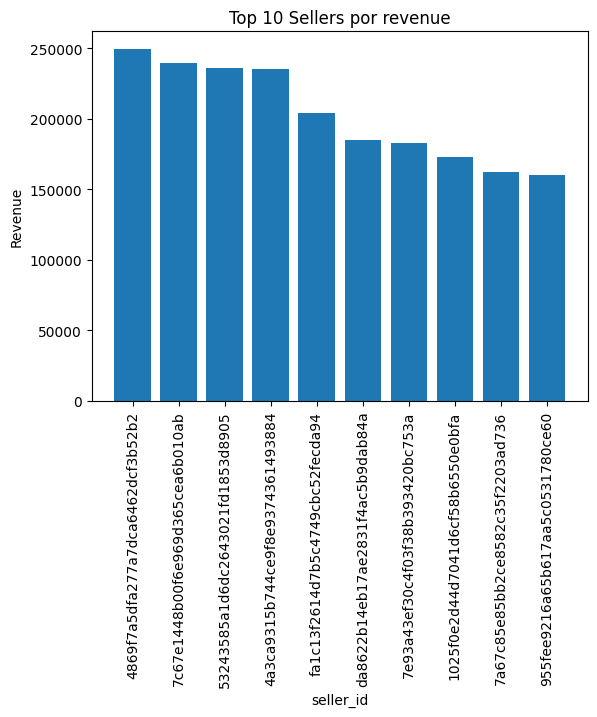

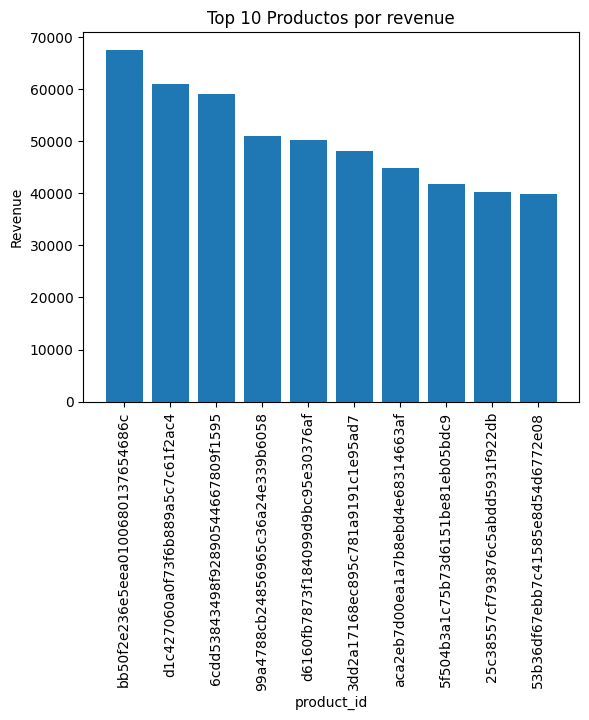

In [ ]:
# celda 7 - Rankings básicos ---
top_sellers = (df.groupby("seller_id", as_index=False)["total_price"].sum()
                 .sort_values("total_price", ascending=False)
                 .head(10))
top_products = (df.groupby("product_id", as_index=False)["total_price"].sum()
                 .sort_values("total_price", ascending=False)
                 .head(10))

display(top_sellers)
display(top_products)

plt.figure()
plt.bar(top_sellers["seller_id"], top_sellers["total_price"])
plt.title("Top 10 Sellers por revenue"); plt.xticks(rotation=90); plt.ylabel("Revenue"); plt.xlabel("seller_id")
plt.show()

plt.figure()
plt.bar(top_products["product_id"], top_products["total_price"])
plt.title("Top 10 Productos por revenue"); plt.xticks(rotation=90); plt.ylabel("Revenue"); plt.xlabel("product_id")
plt.show()


In [ ]:
# celda 8 - Export tablas resumen ---
OUT = PROC / "eda"
OUT.mkdir(parents=True, exist_ok=True)

m_orders.to_csv(OUT / "trend_monthly_orders.csv", index=False)
top_sellers.to_csv(OUT / "top10_sellers_revenue.csv", index=False)
top_products.to_csv(OUT / "top10_products_revenue.csv", index=False)
wd.to_csv(OUT / "on_time_by_weekday.csv", index=False)
hr.to_csv(OUT / "on_time_by_hour.csv", index=False)

"guardado"


'guardado'